In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle 

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_cnn, train, get_all_accuracy_rates, allocate_x_batch_cnn, quantile_score, get_competition_preds


nn_type = 'cnn'
allocate_x_batch = allocate_x_batch_cnn
get_x_sequences = get_x_sequences_cnn

In [2]:
np.random.seed(2021)

case=3
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 25


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([164958, 16])
torch.Size([118382, 1])
2016-01-01 20:00:00
2017-05-01 00:00:00
111927


In [3]:
input_size = x.shape[1]
num_channels = input_size
out_size = 1
num_hidden = 1
drop_p=0.1

kernel_size = 15
stride = 1
padding = kernel_size//2
conv_out_seq = round((pred_seq_len + 2*padding - kernel_size) / stride + 1)
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        self.conv_in = nn.Conv1d(in_channels = input_size, 
                              out_channels = num_channels, 
                              kernel_size = kernel_size, 
                              stride=stride, 
                              padding=padding,
                              groups = input_size)
        self.hidden_list=[]
        for i in range(num_hidden):
            self.hidden_list.append(nn.Conv1d(in_channels = num_channels, 
                                              out_channels = num_channels, 
                                              kernel_size = kernel_size, 
                                              stride=stride, 
                                              padding=padding,
                                              groups = input_size))
        self.l_out = nn.Linear(in_features=conv_out_seq * num_channels,
                               out_features=out_size,
                               bias=True)
        
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_p)
        
        
    def forward(self, x):
        x = self.conv_in(x)
        for hidden_layer in self.hidden_list:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.act(x)
        
        x = x.reshape(-1, conv_out_seq * num_channels)
        x = self.dropout(x)
        x = self.act(x)  
        x = self.l_out(x)
        return x


net = Net()
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

Net(
  (conv_in): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,), groups=16)
  (l_out): Linear(in_features=400, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.1)
)


In [4]:
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 0
k_fold_size = 6

loss = nn.MSELoss()
#loss = nn.L1Loss()


optim_params = {'lr': 3e-3, 'weight_decay': 0.001}
train_loss, valid_loss, net = train(nn_type, x, y, Net, optim_params, num_epochs, batch_size, good_idx, k_fold_size, idx_offset, pred_seq_len, loss, case)
valid_loss[0] = np.sqrt(valid_loss[0])

#np.savez(outfile, train_loss=train_loss, valid_loss=valid_loss)

Fold 0: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 

Fold 1: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 

Fold 2: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 

Fold 3: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 

Fold 4: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 

Fold 5: Training loss: 0.0000, 
Validation metrics: 
mseloss 0.0000 
maeloss 0.0000 
quantile_score_metric 0.0000 
accuracy_rate_metric 0.0000 



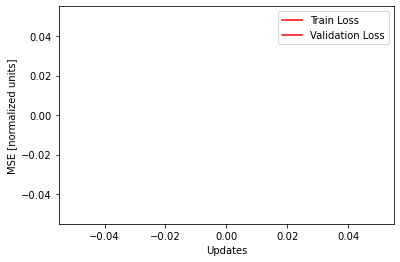

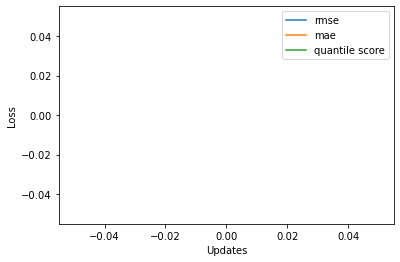

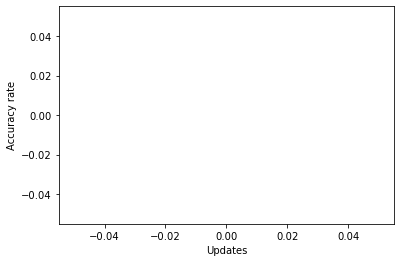

In [5]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('MSE [normalized units]')
plt.show()

plt.figure()
plt.plot(epoch, capacity(case)*np.array(valid_loss[:,:,:].mean(axis=-1)[:-1]).T)
plt.legend(['rmse','mae','quantile score'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, valid_loss[:,:,:].mean(axis=-1)[-1])
plt.xlabel('Updates'), plt.ylabel('Accuracy rate')
plt.show()


In [6]:
#with open(f'final_net/cnn_--num_hidden_1_--kernel_size_17_--pred_seq_len_25_--loss_mse_--weight_decay_0.001_--dropout_0.1_--case_{case}.pkl', 'rb') as inp: 
#with open(f'final_net/cnn_--num_hidden_1_--kernel_size_9_--pred_seq_len_25_--loss_mse_--weight_decay_0_--dropout_0_--case_{case}.pkl', 'rb') as inp:
with open(f'final_net/cnn_--num_hidden_1_--kernel_size_15_--pred_seq_len_25_--loss_mse_--weight_decay_0.001_--dropout_0.1_--case_{case}.pkl', 'rb') as inp: 
    net = pickle.load(inp)

    
split=10
predictions=np.zeros((0,1))
print(predictions.shape)
for i in range(split):
    idx = good_idx[i*len(good_idx)//split:(i+1)*len(good_idx)//split]
    
    x_batch = allocate_x_batch(len(idx), input_size, pred_seq_len)
    predictions = np.vstack((predictions,net(get_x_sequences(idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()))
    print(predictions.shape)
    

(0, 1)
(11192, 1)
(22385, 1)
(33578, 1)
(44770, 1)
(55963, 1)
(67156, 1)
(78348, 1)
(89541, 1)
(100734, 1)
(111927, 1)


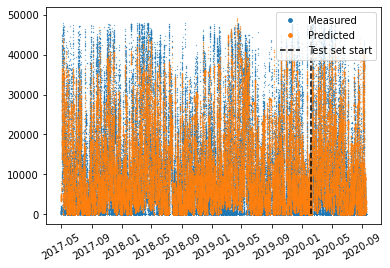

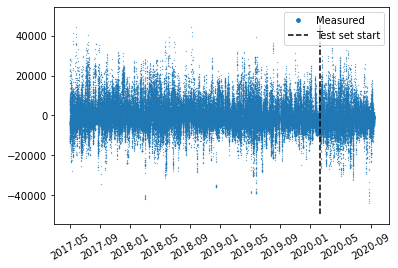

In [7]:
predictions = np.clip(predictions, 0, 1)
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
plt.plot((y_time[good_idx[-20000]],y_time[good_idx[-20000]]), (0, capacity(case)),'--',color='black',label='Test set start')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy()-capacity(case)*predictions, '.', markersize=0.5, label = 'Measured')
plt.plot((y_time[good_idx[-20000]],y_time[good_idx[-20000]]), (-capacity(case), capacity(case)),'--',color='black',label='Test set start')
lgnd = plt.legend(markerscale=15)    
plt.xticks(rotation=30)
plt.show()

In [8]:
print('test accuracy:',accuracy_rate(torch.Tensor(predictions[-20000:]*capacity(case)), y[good_idx[-20000:]]*capacity(case), capacity(case)))
print('val/train accuracy:',accuracy_rate(torch.Tensor(predictions[:-20000]*capacity(case)), y[good_idx[:-20000]]*capacity(case), capacity(case)))



test accuracy: tensor(0.8616)
val/train accuracy: tensor(0.8689)


In [9]:
x_batch = allocate_x_batch(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences, good_idx, idx_offset, pred_seq_len, case)

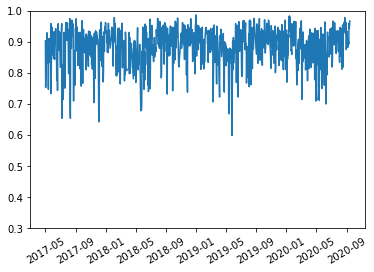

Mean accuracy rate 0.88804734


In [10]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print('Mean accuracy rate', np.mean(accuracies))

In [11]:
day=0
save=False
predictions = get_competition_preds(day,case,get_x_sequences,allocate_x_batch,input_size,pred_seq_len,net,save)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/simon/Documents/DTU/9. semester/deep learning/data/competition/modified/Competition_case_3_day_-1.csv'